# Stroke Modelling
This notebook aims to model the occurence of strokes based on various historical and biometric factors. 

* We will first break down and explore the data
* Then we will treat and prepare the data for visualization and modelling
* We will visualize the data to set up for modelling
* And finally we will test and tune our model

## Data Exploration

In [1]:
#First we will import our Data
import numpy as np
import pandas as pd
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Let's explore and describe our data
original = pd.read_csv('healthcare-dataset-stroke-data.csv')
# We copy the data to preserve the original dataset for categorical histograms.
df = original.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#### There are lots of categorical columns, which limit our ability to gain accurate predictions and explore the data visually. Furthermore, this could feature response bias as people could be withold information about smoking, residence, and work.

In [3]:
#How about other metrics?

df.describe(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


(                 id          age  hypertension  heart_disease  \
 count   5110.000000  5110.000000   5110.000000    5110.000000   
 mean   36517.829354    43.226614      0.097456       0.054012   
 std    21161.721625    22.612647      0.296607       0.226063   
 min       67.000000     0.080000      0.000000       0.000000   
 25%    17741.250000    25.000000      0.000000       0.000000   
 50%    36932.000000    45.000000      0.000000       0.000000   
 75%    54682.000000    61.000000      0.000000       0.000000   
 max    72940.000000    82.000000      1.000000       1.000000   
 
        avg_glucose_level          bmi       stroke  
 count        5110.000000  4909.000000  5110.000000  
 mean          106.147677    28.893237     0.048728  
 std            45.283560     7.854067     0.215320  
 min            55.120000    10.300000     0.000000  
 25%            77.245000    23.500000     0.000000  
 50%            91.885000    28.100000     0.000000  
 75%           114.090000 

In [4]:
# over 200 rows, less than 5%, is missing bmi, but our data set is quite robust.

# how many of those are stroke victims
print(f"stroke victims without bmis {df['stroke'].loc[df['stroke']==1].loc[df['bmi'].isna()].sum()}","\n",f"total stroke victims {df['stroke'].loc[df['stroke']==1].sum()}")
print(f'Stroke victim percentage for those without bmi {(40/201)*100}','\n',f'and stroke victim percentage within the population {(249/5110)*100}')


stroke victims without bmis 40 
 total stroke victims 249
Stroke victim percentage for those without bmi 19.900497512437813 
 and stroke victim percentage within the population 4.87279843444227


This would mean 4 times too many stroke victims would be removed from the dataset
resulting in 12% reduction in relative size. 

We would have only 200 individuals left. Is this worth the extra data?

### Our solution will be to copy the dataset and use 2 models, one with dropped na values and one without bmi.

In [5]:
# Let's first clean the data an remove categorical elements.
df['gender'].loc[df['gender'].isin(['Male', 'Other'])] = 0
df['gender'].loc[df['gender'] == 'Female'] = 1
df['ever_married'].loc[df['ever_married'] == 'No'] = 0
df['ever_married'].loc[df['ever_married'] == 'Yes'] = 1
df['Residence_type'].loc[df['Residence_type']=='Urban'] = 0
df['Residence_type'].loc[df['Residence_type']=='Rural'] = 1
# The work_type and smoking_status columns are too important and discontinuous to give a single value. Lets use dummy values
dummies = pd.get_dummies(df['work_type'],prefix='work')
dummies

C:\Users\fritz\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children
0,0,0,1,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,0,1,0
...,...,...,...,...,...
5105,0,0,1,0,0
5106,0,0,0,1,0
5107,0,0,0,1,0
5108,0,0,1,0,0


In [6]:
#And now the smoking status column dummies
dummies2 = pd.get_dummies(df['smoking_status'])
dummies2

,Unknown,formerly smoked,never smoked,smokes
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,0,1
4,0,0,1,0
...,...,...,...,...
5105,0,0,1,0
5106,0,0,1,0
5107,0,0,1,0
5108,0,1,0,0


In [7]:
# Now we need to replace the 'work_type' column with its dummy counterparts
df.drop(['work_type', 'smoking_status'], axis=1, inplace=True)
df = pd.concat([df,dummies, dummies2], axis=1)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,Unknown,formerly smoked,never smoked,smokes
0,9046,0,67.0,0,1,1,0,228.69,36.6,1,0,0,1,0,0,0,1,0,0
1,51676,1,61.0,0,0,1,1,202.21,NaN,1,0,0,0,1,0,0,0,1,0
2,31112,0,80.0,0,1,1,1,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,60182,1,49.0,0,0,1,0,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,1665,1,79.0,1,0,1,1,174.12,24.0,1,0,0,0,1,0,0,0,1,0


In [8]:
# Let's double check the data types
df.dtypes

id                      int64
gender                 object
age                   float64
hypertension            int64
heart_disease           int64
ever_married           object
Residence_type         object
avg_glucose_level     float64
bmi                   float64
stroke                  int64
work_Govt_job           uint8
work_Never_worked       uint8
work_Private            uint8
work_Self-employed      uint8
work_children           uint8
Unknown                 uint8
formerly smoked         uint8
never smoked            uint8
smokes                  uint8
dtype: object

In [9]:
#Many Columns are still objects. Let's change that
df[['gender','ever_married','Residence_type']]= df[['gender','ever_married', 'Residence_type']].astype('int')
df.dtypes

id                      int64
gender                  int32
age                   float64
hypertension            int64
heart_disease           int64
ever_married            int32
Residence_type          int32
avg_glucose_level     float64
bmi                   float64
stroke                  int64
work_Govt_job           uint8
work_Never_worked       uint8
work_Private            uint8
work_Self-employed      uint8
work_children           uint8
Unknown                 uint8
formerly smoked         uint8
never smoked            uint8
smokes                  uint8
dtype: object

### Recap

Now we have cleaned our model and are ready to break it into the two model sets. 

One will remove rows with na values and use all available factors as independent variables.(df1)

The other will drop bmi as a factor and keep all existing rows (df2)

In [10]:
df2 = df.copy()
df.dropna(inplace=True)
df2.drop('bmi', axis=1, inplace=True)

### Now that we have to separate models, let's explore the difference.

### We will perform groupby calculations by stroke values for each dataset.

## Visualization of Data

In [14]:
# Though we don't have many graphable fields, we can gain some more insight.

# To highlight stroke victims, we will create separate stroke victime scatter data to overlay the original 

sv_1 = df.copy()
sv_2 = df.copy()
sv_1 = sv_1.loc[sv_1['stroke']==1]
sv_2 = sv_2.loc[sv_2['stroke']==1]

# Then we will create variables for bmi from sv_1 and avg_glucose_level from sv_2
stroke_bmi = sv_1['bmi']
stroke_agl = sv_2['avg_glucose_level']



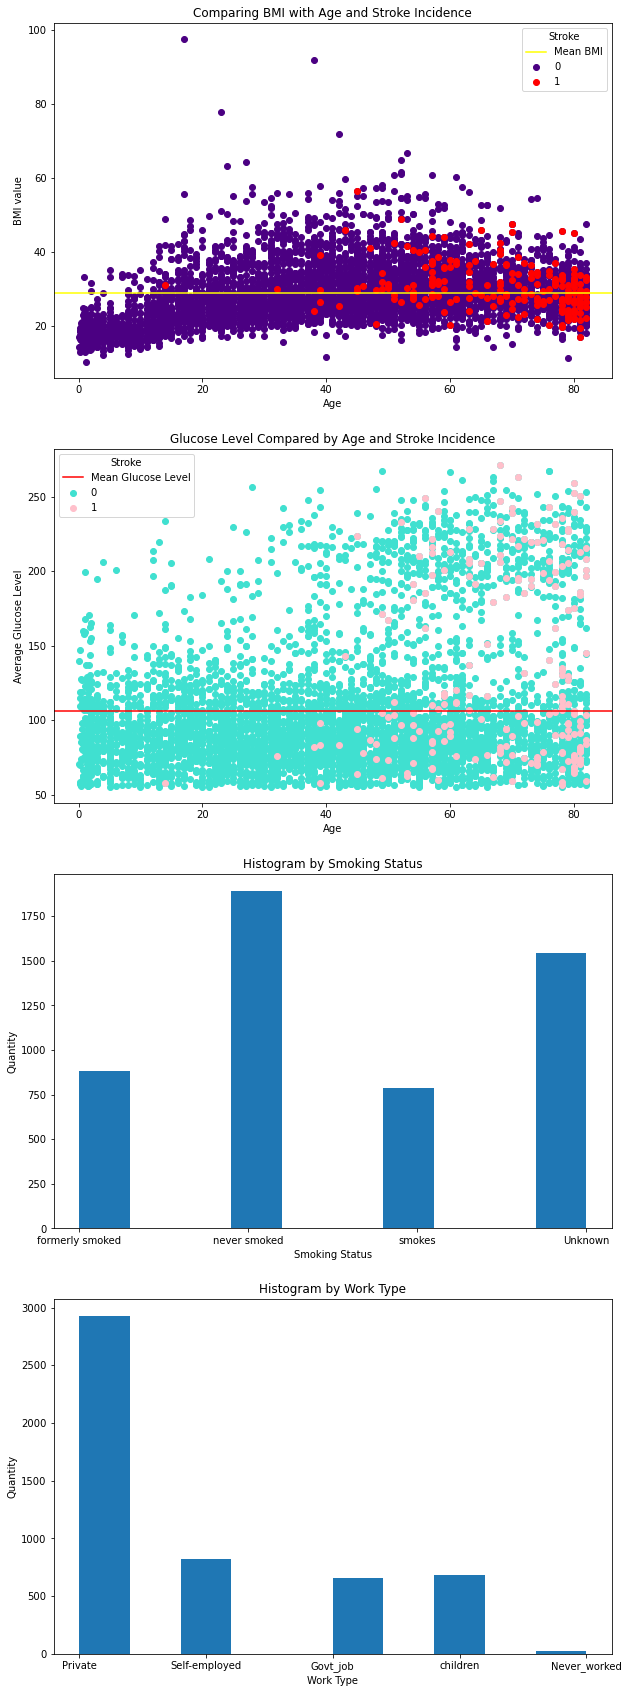

In [18]:

# We'll set up a figure
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(10,30))
ax[0].scatter(x=df['age'], y=df['bmi'], color='indigo', label='0')
ax[0].scatter(x=sv_1['age'], y=stroke_bmi, color='red', label='1')
ax[0].set(title='Comparing BMI with Age and Stroke Incidence', ylabel='BMI value', xlabel='Age')
ax[0].axhline(df['bmi'].mean(), linestyle='-',color='yellow', label='Mean BMI')
ax[0].legend(title='Stroke')
ax[1].scatter(x=df2['age'], y=df2['avg_glucose_level'], color='turquoise', label='0')
ax[1].scatter(x=sv_2['age'], y=stroke_agl, color='pink', label='1')
ax[1].axhline(df2['avg_glucose_level'].mean(), linestyle='-', color='red', label='Mean Glucose Level')
ax[1].legend(title='Stroke')
ax[1].set(title='Glucose Level Compared by Age and Stroke Incidence', ylabel='Average Glucose Level', xlabel='Age')
ax[2].hist(original['smoking_status'])
ax[2].set(title='Histogram by Smoking Status', ylabel='Quantity', xlabel='Smoking Status')
ax[3].hist(original['work_type'])
ax[3].set(title='Histogram by Work Type', ylabel='Quantity', xlabel = 'Work Type')
plt.savefig('stroke-analysis-figure.png');

### Visualization Conclusions

This dataset has very little correllation between variables and stroke incidence.

The histograms also show some problematic variables:
   
There is a high prevalence of individuals whose smoking status is unknown. That dummy column could muddy the larger picture
    
There are multiple work type values who have so few data points it could cause some anomalous fitting in the models to come. 


## Predictive Modelling

In [13]:
# First we will need to split our datasets by dependent and independent variables
X = df.drop('stroke',axis=1)
y = df['stroke']

# This second set of variables will be for the model without bmi values.
X2 = df2.drop('stroke',axis=1)
y2 = df2['stroke']


In [14]:
print('With BMI Column')
print(df.groupby(['stroke']).mean())
print('Without BMI Column')
print(df2.groupby(['stroke']).mean())


With BMI Column
                  id    gender        age  hypertension  heart_disease  \
stroke                                                                   
0       37042.892128  0.590851  41.760451      0.083191       0.043191   
1       37546.038278  0.574163  67.712919      0.287081       0.191388   

        ever_married  Residence_type  avg_glucose_level        bmi  \
stroke                                                               
0           0.642128        0.493404         104.003736  28.823064   
1           0.889952        0.478469         134.571388  30.471292   

        work_Govt_job  work_Never_worked  work_Private  work_Self-employed  \
stroke                                                                       
0            0.128085           0.004681      0.571064            0.153617   
1            0.133971           0.000000      0.607656            0.253589   

        work_children   Unknown  formerly smoked  never smoked    smokes  
stroke            

### It appears that the data set that has removed rows from the dataframe (With BMI) has a larger variance between stroke victims and the greater population. It may be better for modelling, but there is also a chance that it is less representative.

In [19]:
# Let's set up the models and put them to the test

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

x_train2,x_test2, y_train2, y_test2 = train_test_split(X2,y2, test_size=0.2)

knn = KNeighborsClassifier()

# test no 1

knn.fit(x_train, y_train)
knn.score(x_test, y_test)

0.9501018329938901

In [20]:
# Let's see if that value is consistent:
scores=[]
for i in range(25):
    y_preds = knn.predict(x_test)
    scores.append(metrics.accuracy_score(y_preds, y_test))
np.average(scores)

0.9501018329938902

In [ ]:
# While not as high as the accuracies for other models, it seems solid and consistent

In [21]:
# Let's explore the other model
knn.fit(x_train2,y_train2)
knn.score(x_test2,y_test2)

0.949119373776908

In [22]:
# One test has the second set with more rows test higher than the other model. Let's see how consistent that is.
scores = []
for i in range(25):
    y_preds = knn.predict(x_test2)
    scores.append(metrics.accuracy_score(y_preds, y_test2))
np.average(scores)

0.949119373776908

### It certainly appears that the accuracy is higher than the other model by a fraction. Perhaps the increase in representation for the marginally prevalent stroke victims was more important than one added variable.

### Can we continue to refine and improve the model? Let us continue refining the second model.

In [23]:
# The following tests the relative efficiency of the algorithms available in the kneighbour class.
#Which is optimal? Ball tree, kd tree, or brute force?
x_train, x_test, y_train, y_test = train_test_split(X2, y2, test_size=.20)

def ball_tree():
    accuracy_set = []
    kn = KNeighborsClassifier(n_neighbors=4, algorithm='ball_tree')
    for x in range(5):
            kn.fit(x_train, y_train)
            predictions = kn.predict(x_test)
            accuracy_set.append(metrics.accuracy_score(predictions, y_test))
    return print(f'Ball Tree scored {np.average(accuracy_set)}')

def kd_tree():
    accuracy_set = []
    kn = KNeighborsClassifier(n_neighbors=4, algorithm='kd_tree')
    for x in range(5):
            kn.fit(x_train, y_train)
            predictions = kn.predict(x_test)
            accuracy_set.append(metrics.accuracy_score(predictions, y_test))
    return print(f'KD Tree scored {np.average(accuracy_set)}')

def brute():
    accuracy_set = []
    kn = KNeighborsClassifier(n_neighbors=4, algorithm='brute')
    for x in range(5):
            kn.fit(x_train, y_train)
            predictions = kn.predict(x_test)
            accuracy_set.append(metrics.accuracy_score(predictions, y_test))
    return print(f'Brute Force scored {np.average(accuracy_set)}')

%timeit ball_tree()

%timeit kd_tree()

%timeit brute()

Ball Tree scored 0.9520547945205479
Ball Tree scored 0.9520547945205479
Ball Tree scored 0.9520547945205479
Ball Tree scored 0.9520547945205479
Ball Tree scored 0.9520547945205479
Ball Tree scored 0.9520547945205479
Ball Tree scored 0.9520547945205479
Ball Tree scored 0.9520547945205479
259 ms ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
KD Tree scored 0.9520547945205479
KD Tree scored 0.9520547945205479
KD Tree scored 0.9520547945205479
KD Tree scored 0.9520547945205479
KD Tree scored 0.9520547945205479
KD Tree scored 0.9520547945205479
KD Tree scored 0.9520547945205479
KD Tree scored 0.9520547945205479
303 ms ± 5.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Brute Force scored 0.9520547945205479
Brute Force scored 0.9520547945205479
Brute Force scored 0.9520547945205479
Brute Force scored 0.9520547945205479
Brute Force scored 0.9520547945205479
Brute Force scored 0.9520547945205479
Brute Force scored 0.9520547945205479
Brute Force scored 0.9520547945205479
74

## Update:

Model persistence gradually pushed the accuracy of ANY model towards 95+ percent. In the Trials prior, it did appear
that the ball tree algorithm was marginally more accurate for this model, as it outperformed kd tree and brute force algorithms despite modelling before them and their persistent accuracy gain.

In [24]:
# For the sake of future trials, I am dumping a joblib file with this model's experience.
from joblib import dump
dump(knn, 'stroke_model.joblib')

['stroke_model.joblib']